# Flight Fare Price Prediction using ML

This notebook implements the full regression workflow to predict **Total Fare** from travel and airline information [`Flight Price Dataset of Bangladesh`](https://www.kaggle.com/datasets/mahatiratusher/flight-price-dataset-of-bangladesh).

## Objectives
- Frame the business problem as supervised regression
- Clean and transform raw flight data
- Perform EDA and KPI analysis
- Train baseline and advanced regression models
- Optimize with cross-validation and hyperparameter tuning
- Interpret model behavior and summarize business insights
- Save reproducible artifacts (processed data, comparison report, model, figures)

In [26]:
# Necessary Packages to complete the Project
# Data manipulation, visualization, and model development libraries
import warnings
from datetime import datetime
from pathlib import Path
import re
# For data manipulation and visualization
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# For model development and evaluation
from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.metrics import (
    max_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
    r2_score,
)
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor

warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")
pd.set_option("display.max_columns", 120)

In [2]:
# Project Constants and Paths
SEED = 42
ROOT = Path("..")
RAW_PATH = ROOT / "data" / "raw" / "Flight_Price_Dataset_of_Bangladesh.csv"
RUN_TIMESTAMP = datetime.now().strftime("%Y%m%d_%H%M%S")
PROCESSED_PATH = ROOT / "data" / "processed" / f"flight_fares_processed_{RUN_TIMESTAMP}.csv"
REPORTS_PATH = ROOT / "reports"
FIGURES_PATH = REPORTS_PATH / "figures"
MODELS_PATH = ROOT / "models"
MODEL_COMPARISON_PATH = REPORTS_PATH / "model_comparison.csv"
BEST_MODEL_PATH = MODELS_PATH / "best_model.joblib"

FIGURES_PATH.mkdir(parents=True, exist_ok=True)
MODELS_PATH.mkdir(parents=True, exist_ok=True)
PROCESSED_PATH.parent.mkdir(parents=True, exist_ok=True)

def log_save(path: Path, summary: str):
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print(f"[{timestamp}] Saved {path.name}: {summary}")

**Business Question:** How can airlines/travel platforms estimate ticket fares from route, airline, timing, and fare components?  
**ML Task:** Supervised regression  
**Target:** `total_fare`

In [3]:
df_raw = pd.read_csv(RAW_PATH)
print("\nRaw shape:", df_raw.shape)
display(df_raw.head())
df_raw.info()
print("\nNumerial Summary:")
display(df_raw.describe(include="number"))
print("\nCategorical Summary:")
display(df_raw.describe(include="object").T)


Raw shape: (57000, 17)


,Airline,Source,Source Name,Destination,Destination Name,Departure Date & Time,Arrival Date & Time,Duration (hrs),Stopovers,Aircraft Type,Class,Booking Source,Base Fare (BDT),Tax & Surcharge (BDT),Total Fare (BDT),Seasonality,Days Before Departure
0,Malaysian Airlines,CXB,Cox's Bazar Airport,CCU,Netaji Subhas Chandra Bose International Airpo...,2025-11-17 06:25:00,2025-11-17 07:38:10,1.219526,Direct,Airbus A320,Economy,Online Website,21131.225021,5169.683753,26300.908775,Regular,10
1,Cathay Pacific,BZL,Barisal Airport,CGP,"Shah Amanat International Airport, Chittagong",2025-03-16 00:17:00,2025-03-16 00:53:31,0.608638,Direct,Airbus A320,First Class,Travel Agency,11605.395471,200.000000,11805.395471,Regular,14
2,British Airways,ZYL,"Osmani International Airport, Sylhet",KUL,Kuala Lumpur International Airport,2025-12-13 12:03:00,2025-12-13 14:44:22,2.689651,1 Stop,Boeing 787,Economy,Travel Agency,39882.499349,11982.374902,51864.874251,Winter Holidays,83
3,Singapore Airlines,RJH,"Shah Makhdum Airport, Rajshahi",DAC,"Hazrat Shahjalal International Airport, Dhaka",2025-05-30 03:21:00,2025-05-30 04:02:09,0.686054,Direct,Airbus A320,Economy,Direct Booking,4435.607340,200.000000,4635.607340,Regular,56
4,British Airways,SPD,Saidpur Airport,YYZ,Toronto Pearson International Airport,2025-04-25 09:14:00,2025-04-25 23:17:20,14.055609,1 Stop,Airbus A350,Business,Direct Booking,59243.806146,14886.570922,74130.377068,Regular,90


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57000 entries, 0 to 56999
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Airline                57000 non-null  object 
 1   Source                 57000 non-null  object 
 2   Source Name            57000 non-null  object 
 3   Destination            57000 non-null  object 
 4   Destination Name       57000 non-null  object 
 5   Departure Date & Time  57000 non-null  object 
 6   Arrival Date & Time    57000 non-null  object 
 7   Duration (hrs)         57000 non-null  float64
 8   Stopovers              57000 non-null  object 
 9   Aircraft Type          57000 non-null  object 
 10  Class                  57000 non-null  object 
 11  Booking Source         57000 non-null  object 
 12  Base Fare (BDT)        57000 non-null  float64
 13  Tax & Surcharge (BDT)  57000 non-null  float64
 14  Total Fare (BDT)       57000 non-null  float64
 15  Se

,Duration (hrs),Base Fare (BDT),Tax & Surcharge (BDT),Total Fare (BDT),Days Before Departure
count,57000.000000,57000.000000,57000.000000,57000.000000,57000.000000
mean,3.994955,58899.556573,11448.238494,71030.316199,45.460579
std,4.094043,68840.614499,12124.344329,81769.199536,26.015657
min,0.500000,1600.975688,200.000000,1800.975688,1.000000
25%,1.003745,8856.316983,200.000000,9602.699787,23.000000
50%,2.644656,31615.996792,9450.940481,41307.544990,45.000000
75%,5.490104,85722.930389,17513.046160,103800.906963,68.000000
max,15.831719,449222.933770,73383.440066,558987.332444,90.000000



Categorical Summary:


,count,unique,top,freq
Airline,57000,24,US-Bangla Airlines,4496
Source,57000,8,CGP,7241
Source Name,57000,8,"Shah Amanat International Airport, Chittagong",7241
Destination,57000,20,JED,3071
Destination Name,57000,20,"King Abdulaziz International Airport, Jeddah",3071
Departure Date & Time,57000,54126,2025-04-14 20:58:00,4
Arrival Date & Time,57000,56944,2025-04-02 22:40:31,2
Stopovers,57000,3,Direct,36642
Aircraft Type,57000,5,Airbus A320,23970
Class,57000,3,Economy,19112


Normalize the column name:
- remove Special characters and extra space and convert all to lower case
- Remove the _ at the bigining and at the end

In [4]:
def to_snake(name: str) -> str:
    name = name.strip().lower()
    name = re.sub(r"[\(\)৳/&-]+", " ", name)
    name = re.sub(r"[^a-z0-9]+", "_", name)
    return re.sub(r"_+", "_", name).strip("_")

df = df_raw.copy()
df.columns = [to_snake(c) for c in df.columns]

alias_map = {
    "airline": "airline_name",
    "departure_date": "departure_date_and_time",
    "arrival_date": "arrival_date_and_time",
    "class": "class_type",
    "base_fare": "base_fare_bdt",
    "tax_surcharge": "tax_surcharge_bdt",
    "total_fare": "total_fare_bdt",
    "days_left": "days_before_departure",
}

renamed = {}
for col in df.columns:
    for key, canonical in alias_map.items():
        if col == key or col.startswith(key + "_") or key in col:
            renamed[col] = canonical
            break

df = df.rename(columns=renamed)

drop_cols = [c for c in df.columns if c.startswith("unnamed") or c in {"index", "id"}]
if drop_cols:
    df = df.drop(columns=drop_cols)

display(df.head())
print("Columns:", sorted(df.columns.tolist()))

,airline_name,source,source_name,destination,destination_name,departure_date_and_time,arrival_date_and_time,duration_hrs,stopovers,aircraft_type,class_type,booking_source,base_fare_bdt,tax_surcharge_bdt,total_fare_bdt,seasonality,days_before_departure
0,Malaysian Airlines,CXB,Cox's Bazar Airport,CCU,Netaji Subhas Chandra Bose International Airpo...,2025-11-17 06:25:00,2025-11-17 07:38:10,1.219526,Direct,Airbus A320,Economy,Online Website,21131.225021,5169.683753,26300.908775,Regular,10
1,Cathay Pacific,BZL,Barisal Airport,CGP,"Shah Amanat International Airport, Chittagong",2025-03-16 00:17:00,2025-03-16 00:53:31,0.608638,Direct,Airbus A320,First Class,Travel Agency,11605.395471,200.000000,11805.395471,Regular,14
2,British Airways,ZYL,"Osmani International Airport, Sylhet",KUL,Kuala Lumpur International Airport,2025-12-13 12:03:00,2025-12-13 14:44:22,2.689651,1 Stop,Boeing 787,Economy,Travel Agency,39882.499349,11982.374902,51864.874251,Winter Holidays,83
3,Singapore Airlines,RJH,"Shah Makhdum Airport, Rajshahi",DAC,"Hazrat Shahjalal International Airport, Dhaka",2025-05-30 03:21:00,2025-05-30 04:02:09,0.686054,Direct,Airbus A320,Economy,Direct Booking,4435.607340,200.000000,4635.607340,Regular,56
4,British Airways,SPD,Saidpur Airport,YYZ,Toronto Pearson International Airport,2025-04-25 09:14:00,2025-04-25 23:17:20,14.055609,1 Stop,Airbus A350,Business,Direct Booking,59243.806146,14886.570922,74130.377068,Regular,90


Columns: ['aircraft_type', 'airline_name', 'arrival_date_and_time', 'base_fare_bdt', 'booking_source', 'class_type', 'days_before_departure', 'departure_date_and_time', 'destination', 'destination_name', 'duration_hrs', 'seasonality', 'source', 'source_name', 'stopovers', 'tax_surcharge_bdt', 'total_fare_bdt']


## Data Dictionary
A quick metadata table with inferred data types, sample values, and potential issues.

In [5]:
rows = []
for c in df.columns:
    sample_vals = df[c].dropna().astype(str).head(3).tolist()
    issue = ""
    if "fare" in c:
        issue = "Check for negatives/outliers and target leakage risk"
    elif "date" in c or "time" in c:
        issue = "Requires datetime parsing"
    elif df[c].dtype == "object":
        issue = "Categorical consistency/case normalization"
    rows.append({
        "column": c,
        "dtype": str(df[c].dtype),
        "sample_values": " | ".join(sample_vals),
        "potential_issue": issue
    })

data_dictionary = pd.DataFrame(rows).sort_values("column").reset_index(drop=True)
display(data_dictionary)

,column,dtype,sample_values,potential_issue
0,aircraft_type,object,Airbus A320 | Airbus A320 | Boeing 787,Categorical consistency/case normalization
1,airline_name,object,Malaysian Airlines | Cathay Pacific | British ...,Categorical consistency/case normalization
2,arrival_date_and_time,object,2025-11-17 07:38:10 | 2025-03-16 00:53:31 | 20...,Requires datetime parsing
3,base_fare_bdt,float64,21131.22502141266 | 11605.395470566073 | 39882...,Check for negatives/outliers and target leakag...
4,booking_source,object,Online Website | Travel Agency | Travel Agency,Categorical consistency/case normalization
5,class_type,object,Economy | First Class | Economy,Categorical consistency/case normalization
6,days_before_departure,int64,10 | 14 | 83,
7,departure_date_and_time,object,2025-11-17 06:25:00 | 2025-03-16 00:17:00 | 20...,Requires datetime parsing
8,destination,object,CCU | CGP | KUL,Categorical consistency/case normalization
9,destination_name,object,Netaji Subhas Chandra Bose International Airpo...,Categorical consistency/case normalization


## Data Cleaning(Preprocessing) and Feature Engineering

1. Inconcistent city

In [6]:
df_clean = df.copy()

def print_rows(stage: str, frame: pd.DataFrame):
    print(f"{stage}: {len(frame):,} rows")

print_rows("Start", df_clean)

city_alias = {
    "dacca": "Dhaka",
    "dac": "Dhaka",
    "ctg": "Chattogram",
    "chittagong": "Chattogram",
}

for city_col in ["source_name", "destination_name"]:
    if city_col in df_clean.columns:
        df_clean[city_col] = (
            df_clean[city_col].astype(str).str.strip().str.lower().replace(city_alias).str.title()
        )

Start: 57,000 rows


2. Collect data type

In [7]:
# Convert fare and days before departure to numeric
for num_col in ["base_fare_bdt", "tax_surcharge_bdt", "total_fare_bdt", "days_before_departure"]:
    if num_col in df_clean.columns:
        df_clean[num_col] = pd.to_numeric(df_clean[num_col], errors="coerce")

# Convert date columns to datetime
for dt_col in ["departure_date_and_time", "arrival_date_and_time"]:
    if dt_col in df_clean.columns:
        df_clean[dt_col] = pd.to_datetime(df_clean[dt_col], errors="coerce")

3. Total fare missing values

In [8]:
if "total_fare_bdt" not in df_clean.columns:
    df_clean["total_fare_bdt"] = np.nan

if {"base_fare_bdt", "tax_surcharge_bdt"}.issubset(df_clean.columns):
    reconstructed = df_clean["base_fare_bdt"] + df_clean["tax_surcharge_bdt"]
    df_clean["total_fare_bdt"] = df_clean["total_fare_bdt"].fillna(reconstructed)

4. Handle missing values, negative fares, and outliers

In [9]:
for col in df_clean.select_dtypes(include=["number"]).columns:
    df_clean[col] = df_clean[col].fillna(df_clean[col].median())

for col in df_clean.select_dtypes(include=["object"]).columns:
    mode_val = df_clean[col].mode(dropna=True)
    fill_val = mode_val.iloc[0] if not mode_val.empty else "Unknown"
    df_clean[col] = df_clean[col].fillna(fill_val)

fare_cols = [c for c in ["base_fare_bdt", "tax_surcharge_bdt", "total_fare_bdt"] if c in df_clean.columns]
if fare_cols:
    before = len(df_clean)
    df_clean = df_clean[(df_clean[fare_cols] >= 0).all(axis=1)]
    print(f"Removed negative-fare rows: {before - len(df_clean):,}")


Removed negative-fare rows: 0


Deal With oultlines

In [10]:
# Outlier handling: IQR-based capping (winsorization) for numeric columns
numeric_cols_for_outliers = [
    c for c in ["base_fare_bdt", "tax_surcharge_bdt", "total_fare_bdt", "duration_hrs", "days_before_departure"]
    if c in df_clean.columns
]

outlier_report = []
for col in numeric_cols_for_outliers:
    q1 = df_clean[col].quantile(0.25)
    q3 = df_clean[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    outliers_before = ((df_clean[col] < lower) | (df_clean[col] > upper)).sum()
    df_clean[col] = df_clean[col].clip(lower=lower, upper=upper)
    outliers_after = ((df_clean[col] < lower) | (df_clean[col] > upper)).sum()

    outlier_report.append({
        "feature": col,
        "lower_cap": round(lower, 2),
        "upper_cap": round(upper, 2),
        "outliers_before": int(outliers_before),
        "outliers_after": int(outliers_after),
    })

print("\nOutlier capping summary (IQR method):")
display(pd.DataFrame(outlier_report))


Outlier capping summary (IQR method):


,feature,lower_cap,upper_cap,outliers_before,outliers_after
0,base_fare_bdt,-106443.60,201022.85,3772,0
1,tax_surcharge_bdt,-25769.57,43482.62,1226,0
2,total_fare_bdt,-131694.61,245098.22,3409,0
3,duration_hrs,-5.73,12.22,5984,0
4,days_before_departure,-44.50,135.50,0,0


**Outlier strategy used:** IQR-based capping (winsorization).  
For each numeric feature, values outside `[Q1 - 1.5*IQR, Q3 + 1.5*IQR]` are clipped to the boundary instead of dropping rows, which preserves data volume while reducing extreme-value influence on model training.

5. Duplicates check

In [11]:
before_dup = len(df_clean)
df_clean = df_clean.drop_duplicates().reset_index(drop=True)
print(f"Removed duplicate rows: {before_dup - len(df_clean):,}")

Removed duplicate rows: 0


6. Feature engineering

In [12]:
if "departure_date_and_time" in df_clean.columns:
    dep = df_clean["departure_date_and_time"]
    df_clean["month"] = dep.dt.month
    df_clean["day"] = dep.dt.day
    df_clean["weekday"] = dep.dt.day_name()

    def departure_period(hour):
        if pd.isna(hour):
            return "Unknown"
        hour = int(hour)
        if 5 <= hour < 12:
            return "Morning"
        if 12 <= hour < 17:
            return "Afternoon"
        if 17 <= hour < 21:
            return "Evening"
        return "Night"

    df_clean["departure_period"] = dep.dt.hour.apply(departure_period)

print_rows("Final cleaned", df_clean)
display(df_clean.head())

Final cleaned: 57,000 rows


,airline_name,source,source_name,destination,destination_name,departure_date_and_time,arrival_date_and_time,duration_hrs,stopovers,aircraft_type,class_type,booking_source,base_fare_bdt,tax_surcharge_bdt,total_fare_bdt,seasonality,days_before_departure,month,day,weekday,departure_period
0,Malaysian Airlines,CXB,Cox'S Bazar Airport,CCU,Netaji Subhas Chandra Bose International Airpo...,2025-11-17 06:25:00,2025-11-17 07:38:10,1.219526,Direct,Airbus A320,Economy,Online Website,21131.225021,5169.683753,26300.908775,Regular,10,11,17,Monday,Morning
1,Cathay Pacific,BZL,Barisal Airport,CGP,"Shah Amanat International Airport, Chittagong",2025-03-16 00:17:00,2025-03-16 00:53:31,0.608638,Direct,Airbus A320,First Class,Travel Agency,11605.395471,200.000000,11805.395471,Regular,14,3,16,Sunday,Night
2,British Airways,ZYL,"Osmani International Airport, Sylhet",KUL,Kuala Lumpur International Airport,2025-12-13 12:03:00,2025-12-13 14:44:22,2.689651,1 Stop,Boeing 787,Economy,Travel Agency,39882.499349,11982.374902,51864.874251,Winter Holidays,83,12,13,Saturday,Afternoon
3,Singapore Airlines,RJH,"Shah Makhdum Airport, Rajshahi",DAC,"Hazrat Shahjalal International Airport, Dhaka",2025-05-30 03:21:00,2025-05-30 04:02:09,0.686054,Direct,Airbus A320,Economy,Direct Booking,4435.607340,200.000000,4635.607340,Regular,56,5,30,Friday,Night
4,British Airways,SPD,Saidpur Airport,YYZ,Toronto Pearson International Airport,2025-04-25 09:14:00,2025-04-25 23:17:20,12.219642,1 Stop,Airbus A350,Business,Direct Booking,59243.806146,14886.570922,74130.377068,Regular,90,4,25,Friday,Morning


7. Remove Unenecesary Features

In [15]:
essential_cols = ['airline_name','source_name','destination_name', 'duration_hrs',
    'stopovers', 'class_type', 'seasonality', 'days_before_departure', 
    'month','weekday','departure_period', "total_fare_bdt"
]
df_cleaned = df_clean[essential_cols]

In [16]:
display(df_cleaned.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57000 entries, 0 to 56999
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   airline_name           57000 non-null  object 
 1   source_name            57000 non-null  object 
 2   destination_name       57000 non-null  object 
 3   duration_hrs           57000 non-null  float64
 4   stopovers              57000 non-null  object 
 5   class_type             57000 non-null  object 
 6   seasonality            57000 non-null  object 
 7   days_before_departure  57000 non-null  int64  
 8   month                  57000 non-null  int32  
 9   weekday                57000 non-null  object 
 10  departure_period       57000 non-null  object 
 11  total_fare_bdt         57000 non-null  float64
dtypes: float64(2), int32(1), int64(1), object(8)
memory usage: 5.0+ MB


None

## Exploratory Data Analysis

1. Aggregation of Total Fare based on Seasonality, Airline, Source and Destination

In [19]:
group_candidates = [c for c in ["airline_name", "source_name", "destination_name", "seasonality"] if c in df_clean.columns]
if group_candidates:
    for col in group_candidates:
        print(f"\nFare statistics by {col}:")
        display(df_clean.groupby(col, as_index=False)["total_fare_bdt"].agg(["count", "mean", "median", "min", "max", "std"]).sort_values("mean", ascending=False))


Fare statistics by airline_name:


,airline_name,count,mean,median,min,max,std
21,Turkish Airlines,2220,71613.577160,43172.676988,1842.792837,245098.217726,75426.340998
3,AirAsia,2312,70643.055101,42763.823207,1804.132096,245098.217726,75831.376267
6,Cathay Pacific,2282,69800.947937,46282.463647,1805.890639,245098.217726,73652.935844
14,Malaysian Airlines,2292,69659.630307,41938.113797,1872.756076,245098.217726,73781.870176
20,Thai Airways,2316,69390.812847,42898.829061,1814.617172,245098.217726,73898.412325
11,IndiGo,2223,69228.995907,42018.490963,1809.274256,245098.217726,74504.378766
8,Etihad Airways,2267,69110.225633,43723.220688,1828.221490,245098.217726,72733.065075
22,US-Bangla Airlines,4496,69053.083461,41255.331044,1801.196913,245098.217726,73768.408553
2,Air India,2280,68830.523954,42429.622428,1816.371029,245098.217726,73828.579931
12,Kuwait Airways,2262,68691.638547,39584.258564,1806.923044,245098.217726,74368.897211



Fare statistics by source_name:


,source_name,count,mean,median,min,max,std
0,Barisal Airport,7102,69255.209818,43584.805691,1824.634260,245098.217726,73562.782990
4,"Osmani International Airport, Sylhet",7179,68671.024357,42643.366811,1801.196913,245098.217726,73291.346974
5,Saidpur Airport,7043,68326.991438,41149.839323,1812.391403,245098.217726,73181.659829
1,Cox'S Bazar Airport,7049,68072.074993,41133.573253,1804.132096,245098.217726,73170.225808
6,"Shah Amanat International Airport, Chittagong",7241,67601.598787,40416.259523,1809.274256,245098.217726,72942.458497
7,"Shah Makhdum Airport, Rajshahi",7091,67426.174665,39743.686337,1800.975688,245098.217726,73408.040846
2,"Hazrat Shahjalal International Airport, Dhaka",7146,67331.575120,40935.910531,1805.890639,245098.217726,72499.129734
3,Jessore Airport,7149,66509.648099,40819.996718,1808.644603,245098.217726,71501.399104



Fare statistics by destination_name:


,destination_name,count,mean,median,min,max,std
10,Kuala Lumpur International Airport,2968,105429.055964,81756.252321,10825.581629,245098.217726,70481.088993
8,"John F. Kennedy International Airport, New York",3066,105253.632380,80075.970052,10995.468293,245098.217726,71925.643958
19,Toronto Pearson International Airport,2921,104503.579484,80418.694323,11319.420190,245098.217726,71072.924487
11,London Heathrow Airport,2968,104219.265118,79722.047442,10860.274709,245098.217726,71839.056297
2,Dubai International Airport,3005,103873.081406,79052.725804,8813.638627,245098.217726,71900.008604
17,Singapore Changi Airport,3063,103845.214622,79234.275966,10886.555454,245098.217726,71548.183553
18,"Suvarnabhumi Airport, Bangkok",3036,103312.279825,79582.964715,10767.177157,245098.217726,69851.089736
9,"King Abdulaziz International Airport, Jeddah",3071,103273.927610,81748.431408,8723.434170,245098.217726,70089.244801
3,"Hamad International Airport, Doha",2923,102423.164360,79583.131743,8717.065594,245098.217726,70725.332132
6,Istanbul Airport,2940,101647.898168,77231.486727,8650.250568,245098.217726,70999.623071



Fare statistics by seasonality:


,seasonality,count,mean,median,min,max,std
1,Hajj,942,85001.974139,54250.273737,2682.581330,245098.217726,84271.918367
0,Eid,603,83150.271362,56621.233630,2291.602504,245098.217726,80119.253498
3,Winter Holidays,10930,74392.450843,47272.617351,2120.464064,245098.217726,77094.836593
2,Regular,44525,65734.687743,39898.217741,1800.975688,245098.217726,71356.594536


2. Correlation Analysis among Numerical Features

[2026-02-17 15:16:25] Saved correlation_heatmap.png: Correlation heatmap


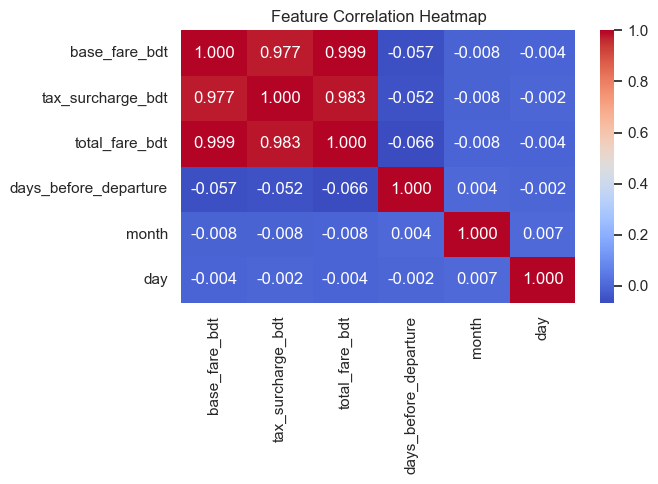

In [20]:
num_for_corr = [c for c in ["base_fare_bdt", "tax_surcharge_bdt", "total_fare_bdt", "days_before_departure", "month", "day"] if c in df_clean.columns]
if len(num_for_corr) > 1:
    corr = df_clean[num_for_corr].corr(numeric_only=True)
    plt.figure(figsize=(7, 5))
    sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".3f")
    plt.title("Feature Correlation Heatmap")
    plt.tight_layout()
    heatmap_path = FIGURES_PATH / "correlation_heatmap.png"
    plt.savefig(heatmap_path, dpi=150)
    log_save(heatmap_path, "Correlation heatmap")
    plt.show()

3. Distributions

[2026-02-17 15:17:23] Saved fare_distributions.png: Fare distributions


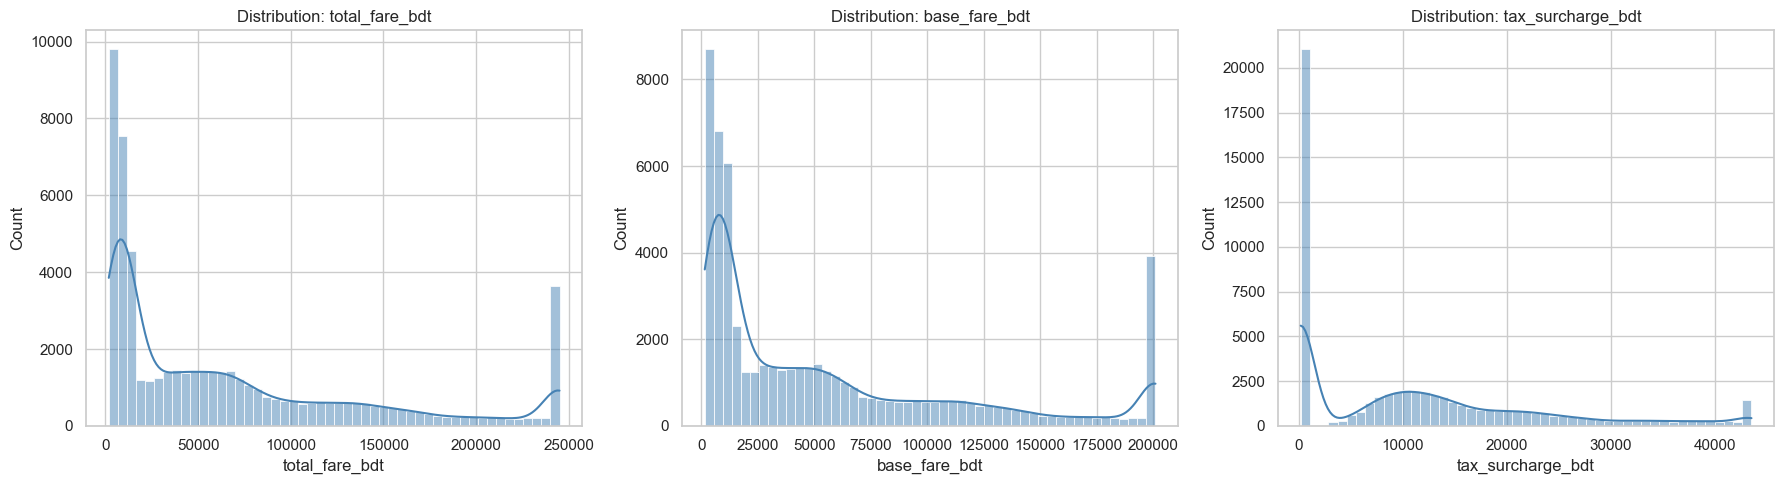

[2026-02-17 15:17:24] Saved fare_by_airline_boxplot.png: Fare by airline boxplot


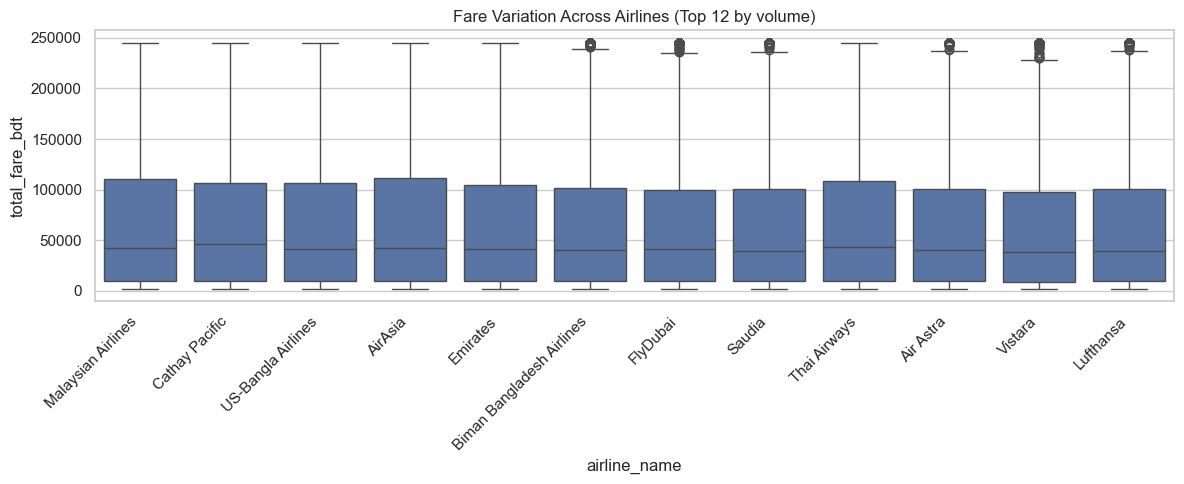

[2026-02-17 15:17:24] Saved fare_by_season_boxplot.png: Fare by season boxplot


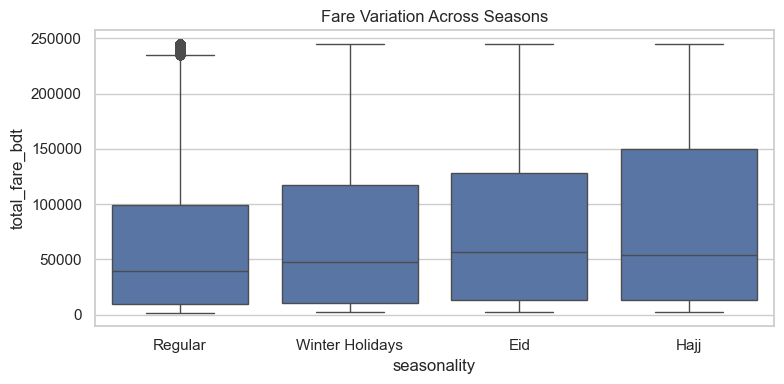

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes = axes.flatten()
for idx, col in enumerate(["total_fare_bdt", "base_fare_bdt", "tax_surcharge_bdt"]):
    if col in df_clean.columns:
        sns.histplot(df_clean[col], kde=True, ax=axes[idx], color="steelblue")
        axes[idx].set_title(f"Distribution: {col}")
plt.tight_layout()
dist_path = FIGURES_PATH / "fare_distributions.png"
plt.savefig(dist_path, dpi=150)
log_save(dist_path, "Fare distributions")
plt.show()

if {"airline_name", "total_fare_bdt"}.issubset(df_clean.columns):
    top_airlines = df_clean["airline_name"].value_counts().head(12).index
    plt.figure(figsize=(12, 5))
    sns.boxplot(data=df_clean[df_clean["airline_name"].isin(top_airlines)], x="airline_name", y="total_fare_bdt")
    plt.xticks(rotation=45, ha="right")
    plt.title("Fare Variation Across Airlines (Top 12 by volume)")
    plt.tight_layout()
    airline_box_path = FIGURES_PATH / "fare_by_airline_boxplot.png"
    plt.savefig(airline_box_path, dpi=150)
    log_save(airline_box_path, "Fare by airline boxplot")
    plt.show()

if {"seasonality", "total_fare_bdt"}.issubset(df_clean.columns):
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=df_clean, x="seasonality", y="total_fare_bdt")
    plt.title("Fare Variation Across Seasons")
    plt.tight_layout()
    season_box_path = FIGURES_PATH / "fare_by_season_boxplot.png"
    plt.savefig(season_box_path, dpi=150)
    log_save(season_box_path, "Fare by season boxplot")
    plt.show()

## Model Development (Baseline + Advanced)

In [22]:
target = "total_fare_bdt"
exclude_cols = {target, "departure_date_and_time", "arrival_date_and_time"}
feature_cols = [c for c in df_cleaned.columns if c not in exclude_cols]

X = df_cleaned[feature_cols].copy()
y = df_cleaned[target].copy()

numeric_features = X.select_dtypes(include=["number"]).columns.tolist()
categorical_features = X.select_dtypes(exclude=["number"]).columns.tolist()

print("Numeric feature count:", len(numeric_features))
print("Categorical feature count:", len(categorical_features))
print("Sample numeric features:", numeric_features[:10])
print("Sample categorical features:", categorical_features[:10])
print("\nMissing values before split (top 10):")
display(X.isna().sum().sort_values(ascending=False).head(10))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=SEED
)

Numeric feature count: 3
Categorical feature count: 8
Sample numeric features: ['duration_hrs', 'days_before_departure', 'month']
Sample categorical features: ['airline_name', 'source_name', 'destination_name', 'stopovers', 'class_type', 'seasonality', 'weekday', 'departure_period']

Missing values before split (top 10):


airline_name             0
source_name              0
destination_name         0
duration_hrs             0
stopovers                0
class_type               0
seasonality              0
days_before_departure    0
month                    0
weekday                  0
dtype: int64

### Preprocessing Pipeline

In [33]:

# End-to-end modeling pipeline:
# preprocess -> train -> tune -> evaluate -> save best model
# ============================================================

target = "total_fare_bdt"
drop_if_present = ["departure_date_and_time", "arrival_date_and_time"]

for c in drop_if_present:
    if c in df_cleaned.columns:
        df_cleaned = df_cleaned.drop(columns=c)

feature_cols = [c for c in df_cleaned.columns if c != target]
X = df_cleaned[feature_cols].copy()
y = pd.to_numeric(df_cleaned[target], errors="coerce")

# keep valid target rows only
valid_idx = y.notna()
X = X.loc[valid_idx].reset_index(drop=True)
y = y.loc[valid_idx].reset_index(drop=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)

numeric_features = X.select_dtypes(include=["number"]).columns.tolist()
categorical_features = X.select_dtypes(exclude=["number"]).columns.tolist()

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Numeric features ({len(numeric_features)}): {numeric_features}")
print(f"Categorical features ({len(categorical_features)}): {categorical_features}")

# ---------- Preprocessing ----------
numeric_linear = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

numeric_tree = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
])

categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

preprocessor_linear = ColumnTransformer([
    ("num", numeric_linear, numeric_features),
    ("cat", categorical_pipe, categorical_features),
])

preprocessor_tree = ColumnTransformer([
    ("num", numeric_tree, numeric_features),
    ("cat", categorical_pipe, categorical_features),
])

def evaluate(y_true, y_pred):
    y_true = pd.Series(y_true).astype(float).to_numpy()
    y_pred = pd.Series(y_pred).astype(float).to_numpy()

    try:
        rmse = mean_squared_error(y_true, y_pred, squared=False)
    except TypeError:
        rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))

    eps = 1e-8
    denom = np.where(np.abs(y_true) < eps, eps, np.abs(y_true))
    mape = float(np.mean(np.abs((y_true - y_pred) / denom)))

    return {
        "R2": float(r2_score(y_true, y_pred)),
        "MAE": float(mean_absolute_error(y_true, y_pred)),
        "MAPE": mape,
        "RMSE": float(rmse),
        "MaxError": float(max_error(y_true, y_pred)),
    }

# ---------- Baseline models ----------
models = {
    "LinearRegression": (LinearRegression(), preprocessor_linear),
    "Ridge": (Ridge(random_state=SEED), preprocessor_linear),
    "Lasso": (Lasso(random_state=SEED, max_iter=5000), preprocessor_linear),
    "DecisionTree": (DecisionTreeRegressor(random_state=SEED), preprocessor_tree),
    "RandomForest": (RandomForestRegressor(random_state=SEED, n_jobs=-1), preprocessor_tree),
    "GradientBoosting": (GradientBoostingRegressor(random_state=SEED), preprocessor_tree),
}

trained_pipelines = {}
baseline_rows = []

for name, (model, prep) in models.items():
    pipe = Pipeline([("prep", prep), ("model", model)])
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)

    row = evaluate(y_test, pred)
    row["Model"] = name
    row["Stage"] = "Baseline"

    baseline_rows.append(row)
    trained_pipelines[name] = pipe

baseline_df = pd.DataFrame(baseline_rows)

# ---------- Hyperparameter tuning ----------
search_spaces = {
    "Ridge": {
        "type": "grid",
        "params": {"model__alpha": [0.01, 0.1, 1.0, 10.0, 50.0]},
    },
    "Lasso": {
        "type": "grid",
        "params": {"model__alpha": [0.0005, 0.001, 0.01, 0.1, 1.0]},
    },
    "RandomForest": {
        "type": "random",
        "params": {
            "model__n_estimators": [100, 200, 300],
            "model__max_depth": [None, 10, 20, 30],
            "model__min_samples_split": [2, 5, 10],
            "model__min_samples_leaf": [1, 2, 4],
        },
        "n_iter": 12,
    },
    "GradientBoosting": {
        "type": "random",
        "params": {
            "model__n_estimators": [100, 200, 300],
            "model__learning_rate": [0.01, 0.05, 0.1, 0.2],
            "model__max_depth": [2, 3, 4],
            "model__subsample": [0.8, 1.0],
        },
        "n_iter": 12,
    },
}

tuned_rows = []

for name, cfg in search_spaces.items():
    base_pipe = clone(trained_pipelines[name])

    if cfg["type"] == "grid":
        search = GridSearchCV(
            estimator=base_pipe,
            param_grid=cfg["params"],
            cv=3,
            scoring="neg_root_mean_squared_error",
            n_jobs=-1,
        )
    else:
        search = RandomizedSearchCV(
            estimator=base_pipe,
            param_distributions=cfg["params"],
            n_iter=cfg.get("n_iter", 10),
            cv=3,
            scoring="neg_root_mean_squared_error",
            random_state=SEED,
            n_jobs=-1,
        )

    search.fit(X_train, y_train)
    best_pipe = search.best_estimator_
    pred = best_pipe.predict(X_test)

    row = evaluate(y_test, pred)
    row["Model"] = f"{name}_Tuned"
    row["Stage"] = "Tuned"
    row["CV_Best_RMSE"] = float(-search.best_score_)
    row["BestParams"] = str(search.best_params_)

    tuned_rows.append(row)
    trained_pipelines[f"{name}_Tuned"] = best_pipe

tuned_df = pd.DataFrame(tuned_rows)

# ---------- Final comparison ----------
all_results = pd.concat([baseline_df, tuned_df], ignore_index=True, sort=False)
all_results["generated_at"] = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
all_results = all_results.sort_values("RMSE").reset_index(drop=True)
display(all_results)

best_model_name = all_results.loc[0, "Model"]
best_model = trained_pipelines[best_model_name]
print(f"Best model: {best_model_name}")
print(f"Best RMSE: {all_results.loc[0, 'RMSE']:.4f}, R2: {all_results.loc[0, 'R2']:.4f}")

# ---------- Save artifacts ----------
all_results.to_csv(MODEL_COMPARISON_PATH, index=False)
log_save(MODEL_COMPARISON_PATH, f"models={all_results['Model'].nunique()}, metrics={', '.join(['R2','MAE','MAPE','RMSE','MaxError'])}")

joblib.dump(best_model, BEST_MODEL_PATH)
log_save(BEST_MODEL_PATH, f"best_model={best_model_name}")

Train shape: (45600, 11), Test shape: (11400, 11)
Numeric features (3): ['duration_hrs', 'days_before_departure', 'month']
Categorical features (8): ['airline_name', 'source_name', 'destination_name', 'stopovers', 'class_type', 'seasonality', 'weekday', 'departure_period']


,R2,MAE,MAPE,RMSE,MaxError,Model,Stage,CV_Best_RMSE,BestParams,generated_at
0,0.713975,24934.986794,0.460274,38865.007602,152106.955299,GradientBoosting_Tuned,Tuned,38878.729810,"{'model__subsample': 1.0, 'model__n_estimators...",2026-02-17 21:17:05
1,0.713425,25057.000852,0.473391,38902.359448,158501.181123,GradientBoosting,Baseline,NaN,NaN,2026-02-17 21:17:05
2,0.712065,24859.171620,0.439111,38994.558043,161775.679035,RandomForest_Tuned,Tuned,39060.862469,"{'model__n_estimators': 100, 'model__min_sampl...",2026-02-17 21:17:05
3,0.699020,25172.555470,0.442915,39868.134017,172275.423628,RandomForest,Baseline,NaN,NaN,2026-02-17 21:17:05
4,0.613892,36190.680436,2.244251,45155.556309,130279.788212,Lasso,Baseline,NaN,NaN,2026-02-17 21:17:05
5,0.613892,36190.680436,2.244251,45155.556309,130279.788212,Lasso_Tuned,Tuned,45302.018340,{'model__alpha': 1.0},2026-02-17 21:17:05
6,0.613885,36191.050307,2.244156,45155.990335,130317.150313,Ridge,Baseline,NaN,NaN,2026-02-17 21:17:05
7,0.613883,36194.927285,2.245666,45156.119226,130214.824263,Ridge_Tuned,Tuned,45302.791905,{'model__alpha': 0.01},2026-02-17 21:17:05
8,0.613882,36194.979298,2.245677,45156.158934,130229.397098,LinearRegression,Baseline,NaN,NaN,2026-02-17 21:17:05
9,0.420624,32421.557871,0.545050,55314.276385,218878.920798,DecisionTree,Baseline,NaN,NaN,2026-02-17 21:17:05


Best model: GradientBoosting_Tuned
Best RMSE: 38865.0076, R2: 0.7140
[2026-02-17 21:17:05] Saved model_comparison.csv: models=10, metrics=R2, MAE, MAPE, RMSE, MaxError
[2026-02-17 21:17:05] Saved best_model.joblib: best_model=GradientBoosting_Tuned


[2026-02-17 21:44:43] Saved linear_regression_diagnostics.png: Actual-vs-predicted and residual diagnostics


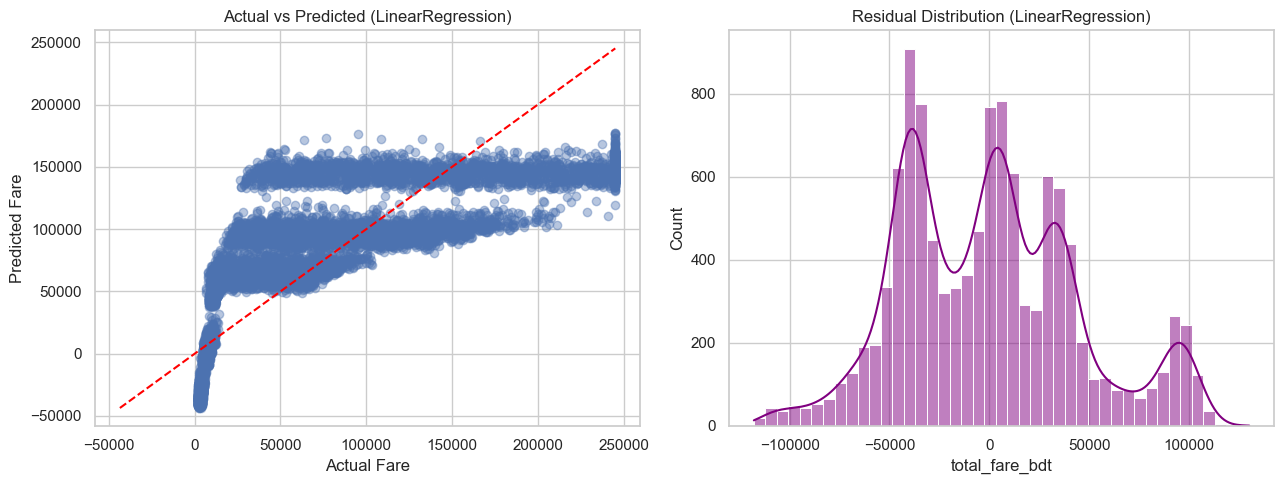

In [34]:
baseline_pipe = trained_pipelines["LinearRegression"]
baseline_pred = baseline_pipe.predict(X_test)

fig, axes = plt.subplots(1, 2, figsize=(13, 5))
axes[0].scatter(y_test, baseline_pred, alpha=0.4)
min_val = min(float(y_test.min()), float(baseline_pred.min()))
max_val = max(float(y_test.max()), float(baseline_pred.max()))
axes[0].plot([min_val, max_val], [min_val, max_val], color="red", linestyle="--")
axes[0].set_title("Actual vs Predicted (LinearRegression)")
axes[0].set_xlabel("Actual Fare")
axes[0].set_ylabel("Predicted Fare")

residuals = y_test - baseline_pred
sns.histplot(residuals, kde=True, ax=axes[1], color="purple")
axes[1].set_title("Residual Distribution (LinearRegression)")

plt.tight_layout()
diag_path = FIGURES_PATH / "linear_regression_diagnostics.png"
plt.savefig(diag_path, dpi=150)
log_save(diag_path, "Actual-vs-predicted and residual diagnostics")
plt.show()

## F) Hyperparameter Optimization and Cross-Validation

In [32]:
alphas = np.logspace(-3, 2, 8)
ridge_train_rmse = []
ridge_test_rmse = []
lasso_train_rmse = []
lasso_test_rmse = []

for alpha in alphas:
    ridge_pipe = Pipeline([("prep", preprocessor_linear), ("model", Ridge(alpha=alpha, random_state=SEED))])
    lasso_pipe = Pipeline([("prep", preprocessor_linear), ("model", Lasso(alpha=alpha, random_state=SEED, max_iter=5000))])

    ridge_pipe.fit(X_train, y_train)
    lasso_pipe.fit(X_train, y_train)

    ridge_train_rmse.append(mean_squared_error(y_train, ridge_pipe.predict(X_train), squared=False))
    ridge_test_rmse.append(mean_squared_error(y_test, ridge_pipe.predict(X_test), squared=False))
    lasso_train_rmse.append(mean_squared_error(y_train, lasso_pipe.predict(X_train), squared=False))
    lasso_test_rmse.append(mean_squared_error(y_test, lasso_pipe.predict(X_test), squared=False))

plt.figure(figsize=(10, 5))
plt.plot(alphas, ridge_train_rmse, marker="o", label="Ridge Train RMSE")
plt.plot(alphas, ridge_test_rmse, marker="o", label="Ridge Test RMSE")
plt.plot(alphas, lasso_train_rmse, marker="s", label="Lasso Train RMSE")
plt.plot(alphas, lasso_test_rmse, marker="s", label="Lasso Test RMSE")
plt.xscale("log")
plt.xlabel("Alpha (log scale)")
plt.ylabel("RMSE")
plt.title("Regularization Effect: Bias-Variance Trend")
plt.legend()
plt.tight_layout()
reg_path = FIGURES_PATH / "regularization_bias_variance.png"
plt.savefig(reg_path, dpi=150)
log_save(reg_path, "Regularization bias-variance plot")
plt.show()

TypeError: got an unexpected keyword argument 'squared'

## G) Model Interpretation

,R2,MAE,MAPE,RMSE,MaxError,Model,Stage,CV_Best_RMSE,BestParams,generated_at
0,0.713975,24934.986794,0.460274,38865.007602,152106.955299,GradientBoosting_Tuned,Tuned,38878.729810,"{'model__subsample': 1.0, 'model__n_estimators...",2026-02-17 21:45:47
1,0.713988,25057.523737,0.476341,38944.461957,158739.122732,GradientBoosting,NaN,NaN,NaN,2026-02-17 21:45:47
2,0.712065,24859.171620,0.439111,38994.558043,161775.679035,RandomForest_Tuned,Tuned,39060.862469,"{'model__n_estimators': 100, 'model__min_sampl...",2026-02-17 21:45:47
3,0.699856,25199.314101,0.442310,39895.007743,177391.693750,RandomForest,NaN,NaN,NaN,2026-02-17 21:45:47
4,0.613892,36190.680436,2.244251,45155.556309,130279.788212,Lasso_Tuned,Tuned,45302.018340,{'model__alpha': 1.0},2026-02-17 21:45:47
5,0.613883,36194.927285,2.245666,45156.119226,130214.824263,Ridge_Tuned,Tuned,45302.791905,{'model__alpha': 0.01},2026-02-17 21:45:47
6,0.613328,36301.041570,2.274167,45281.916655,131730.349749,Lasso,NaN,NaN,NaN,2026-02-17 21:45:47
7,0.613312,36305.915167,2.275558,45282.876834,131677.951170,LinearRegression,NaN,NaN,NaN,2026-02-17 21:45:47
8,0.613311,36301.528283,2.273975,45282.946111,131777.767142,Ridge,NaN,NaN,NaN,2026-02-17 21:45:47
9,0.409505,32850.397065,0.553105,55957.956103,219883.261298,DecisionTree,NaN,NaN,NaN,2026-02-17 21:45:47


Best model: GradientBoosting_Tuned


,feature,importance
0,num__duration_hrs,0.452775
60,cat__class_type_First Class,0.355756
47,cat__destination_name_Netaji Subhas Chandra Bo...,0.102078
59,cat__class_type_Economy,0.034422
58,cat__class_type_Business,0.033130
1,num__days_before_departure,0.011811
63,cat__seasonality_Regular,0.006723
62,cat__seasonality_Hajj,0.001011
2,num__month,0.000423
30,cat__source_name_Jessore Airport,0.000286


[2026-02-17 21:45:47] Saved tree_feature_importance.png: Tree feature importance plot


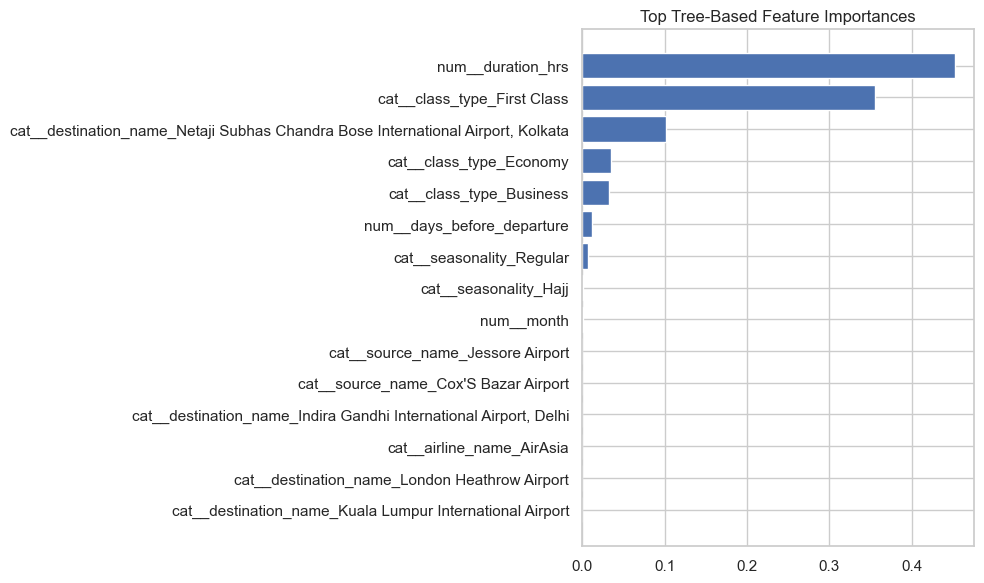

In [35]:
all_results = pd.concat([results_df, tuned_df], ignore_index=True, sort=False)
all_results["generated_at"] = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
all_results = all_results.sort_values("RMSE").reset_index(drop=True)
display(all_results)

best_model_name = all_results.iloc[0]["Model"]
best_model = trained_pipelines[best_model_name]
print(f"Best model: {best_model_name}")

if best_model_name.startswith("LinearRegression") or best_model_name.startswith("Ridge") or best_model_name.startswith("Lasso"):
    prep = best_model.named_steps["prep"]
    model = best_model.named_steps["model"]
    feature_names = prep.get_feature_names_out()
    coef_df = pd.DataFrame({
        "feature": feature_names,
        "coefficient": model.coef_.ravel()
    }).sort_values("coefficient", key=np.abs, ascending=False)
    display(coef_df.head(20))

    plt.figure(figsize=(10, 6))
    top = coef_df.head(15).iloc[::-1]
    plt.barh(top["feature"], top["coefficient"])
    plt.title("Top Linear Feature Effects")
    plt.tight_layout()
    coef_path = FIGURES_PATH / "linear_feature_effects.png"
    plt.savefig(coef_path, dpi=150)
    log_save(coef_path, "Linear coefficients importance plot")
    plt.show()

if "RandomForest" in best_model_name or "DecisionTree" in best_model_name or "GradientBoosting" in best_model_name:
    prep = best_model.named_steps["prep"]
    model = best_model.named_steps["model"]
    feature_names = prep.get_feature_names_out()
    imp_df = pd.DataFrame({
        "feature": feature_names,
        "importance": model.feature_importances_
    }).sort_values("importance", ascending=False)
    display(imp_df.head(20))

    plt.figure(figsize=(10, 6))
    top = imp_df.head(15).iloc[::-1]
    plt.barh(top["feature"], top["importance"])
    plt.title("Top Tree-Based Feature Importances")
    plt.tight_layout()
    imp_path = FIGURES_PATH / "tree_feature_importance.png"
    plt.savefig(imp_path, dpi=150)
    log_save(imp_path, "Tree feature importance plot")
    plt.show()

## H) Persist Artifacts and Executive Summary

In [ ]:
df_clean.to_csv(PROCESSED_PATH, index=False)
log_save(PROCESSED_PATH, f"rows={len(df_clean):,}, cols={len(df_clean.columns)}")

all_results.to_csv(MODEL_COMPARISON_PATH, index=False)
log_save(MODEL_COMPARISON_PATH, f"models={all_results['Model'].nunique()}, metrics={', '.join(['R2','MAE','MAPE','RMSE','MaxError'])}")

joblib.dump(best_model, BEST_MODEL_PATH)
log_save(BEST_MODEL_PATH, f"best_model={best_model_name}")

summary_lines = [
    "### Executive Summary",
    f"- Best model: **{best_model_name}**",
    f"- Best RMSE: **{all_results.iloc[0]['RMSE']:.4f}**",
    f"- Best R2: **{all_results.iloc[0]['R2']:.4f}**",
    "- Key drivers should be interpreted from the coefficient/importance plots above.",
    "- Recommendation: use the best model for fare estimation and schedule periodic retraining as market patterns shift."
]
print('\n'.join(summary_lines))

[2026-02-17 21:47:03] Saved flight_fares_processed_20260217_150720.csv: rows=57,000, cols=21
[2026-02-17 21:47:03] Saved model_comparison.csv: models=10, metrics=R2, MAE, MAPE, RMSE, MaxError
[2026-02-17 21:47:03] Saved best_model.joblib: best_model=GradientBoosting_Tuned
### Executive Summary
- Best model: **GradientBoosting_Tuned**
- Best RMSE: **38865.0076**
- Best R2: **0.7140**
- Key drivers should be interpreted from the coefficient/importance plots above.
- Recommendation: use the best model for fare estimation and schedule periodic retraining as market patterns shift.
- Limitation: including fare components (`base_fare`, `tax_surcharge`) can inflate predictive power versus pure pre-pricing scenarios.
